# Using LASSO to Predict Sector ETF Returns

## Imports

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Functions for Model/Signal Creation and Backtesting

In [ ]:
def fetch_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

In [ ]:
def compute_returns(data):
    returns = data.pct_change().dropna()
    return returns

In [ ]:
def train_lasso(X_train, y_train, alpha=1e-6):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    return lasso

In [ ]:
def train_alasso(X_train, y_train, alpha=1e-6):
    gprime = lambda w: 1. / (2. * np.sqrt(np.abs(w)) + np.finfo(float).eps)
    _, n_features = X_train.shape
    weights = np.ones(n_features)

    for k in range(5):
        X_w = X / weights[np.newaxis, :]
        a_lasso = Lasso(alpha=alpha)
        a_lasso.fit(X_w, y)
        coef_ = a_lasso.coef_ / weights
        weights = gprime(coef_)

    return a_lasso

In [ ]:
def generate_signals(lasso_model, X_data):
    predictions = lasso_model.predict(X_data)
    signals = pd.Series(predictions, index=X_data.index)
    print(signals)
    signals = signals.apply(lambda x: 1 if x > 0 else -1)
    return signals

In [ ]:
import pandas as pd

def generate_signals_regressive(lasso_model, X_data):
    # Generate predictions (regression values) using the lasso model
    predictions = lasso_model.predict(X_data)

    # Create a Pandas Series for the predictions to associate them with the original index
    regression_values = pd.Series(predictions, index=X_data.index)

    # Return only the regression values
    return regression_values

In [ ]:
def backtest(returns, signals, initial_capital):
    plt.style.use('seaborn-darkgrid')

    # Ensure signals are aligned with returns
    signals = signals.shift(1)  # simulate trade execution delay
    df = pd.DataFrame({'ETF': returns, 'signal': signals}).dropna()

    # Calculate strategy returns
    strategy_returns = df['ETF'] * df['signal']

    # Compute portfolio value over time
    portfolio_returns = strategy_returns + 1  # Add 1 to include capital
    portfolio_values = initial_capital * portfolio_returns.cumprod()

    # Plotting the strategy performance
    plt.figure(figsize=(12, 6))
    portfolio_values.plot(label='Portfolio Value', linewidth=2, color='blue')
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Value ($)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Data Cleaning and Aggregation

In [94]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
start_date = '2022-01-01'
end_date = '2023-01-01'

data = fetch_data(tickers, start_date, end_date)
returns = compute_returns(data)
X = returns.drop(columns='SPY')
y = returns['SPY']

[*********************100%%**********************]  5 of 5 completed


In [ ]:
y_shift = y.shift(-1)

In [ ]:
y

Date
2018-01-03    0.006325
2018-01-04    0.004215
2018-01-05    0.006664
2018-01-08    0.001829
2018-01-09    0.002263
                ...   
2020-12-24    0.003890
2020-12-28    0.008591
2020-12-29   -0.001908
2020-12-30    0.001427
2020-12-31    0.005081
Name: SPY, Length: 755, dtype: float64

In [ ]:
y_shift = y_shift.dropna()
X_shift = X[:-1]

## Training and Testing on SPY ETF

In [ ]:
def prepare_features(data):
    # Calculate 5-day rolling averages, shift to ensure no future data leakage
    return data.rolling(window=3).mean()

Date
2022-06-01    0.000661
2022-06-02    0.001713
2022-06-03    0.001626
2022-06-06    0.001445
2022-06-07   -0.000246
                ...   
2022-12-23   -0.000960
2022-12-27    0.000002
2022-12-28    0.001846
2022-12-29    0.000574
2022-12-30    0.000207
Length: 148, dtype: float64


<ipython-input-7-06eed7143687>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


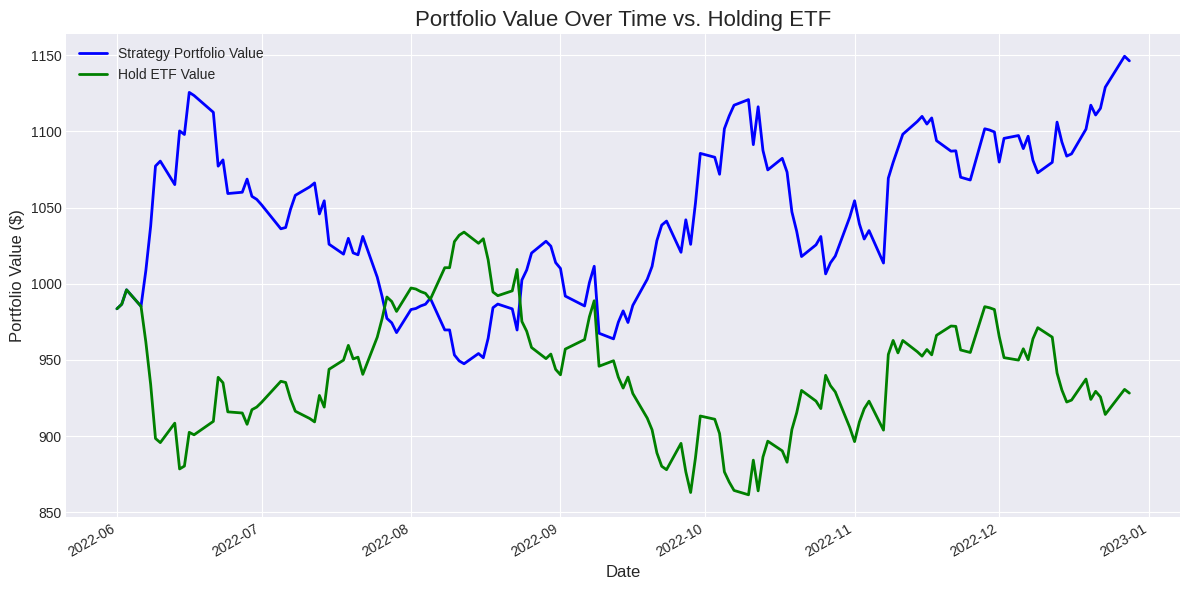

In [95]:
# Example setup with date cutoff
cutoff_date = '2022-06-01'  # Choose an appropriate cutoff date

# Prepare the features using rolling windows
X_rolled = prepare_features(X)
y_rolled = y.shift(-2)  # Align target with the input features

# Drop rows with NaN values which might be introduced by rolling and shifting
X_rolled = X_rolled.dropna()
y_rolled = y_rolled.dropna()[2:]

# Split the data chronologically
X_train = X_rolled.loc[X_rolled.index < cutoff_date]
X_test = X_rolled.loc[X_rolled.index >= cutoff_date]
y_train = y_rolled.loc[y_rolled.index < cutoff_date]
y_test = y_rolled.loc[y_rolled.index >= cutoff_date]

# Train the Lasso model and generate signals
lasso_model = train_lasso(X_train, y_train)
signals = generate_signals(lasso_model, X_test)

# Backtest the strategy
cumulative_returns = backtest(y_test, signals, 1000)

In [ ]:
X_test

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-06-01,0.003921,0.008357,0.003426,0.001884
2020-06-02,0.005318,0.009827,0.005634,0.006428
2020-06-03,0.007478,0.004905,0.001335,0.003839
2020-06-04,0.000507,-0.001402,-0.004757,0.000216
2020-06-05,0.008458,0.001448,-0.000424,0.004223
...,...,...,...,...
2020-12-24,0.009734,-0.003490,-0.000060,0.000284
2020-12-28,0.012167,0.008165,0.010346,0.001570
2020-12-29,0.010054,0.014235,0.005750,0.004716


Date
2020-06-01    0.000291
2020-06-02    0.000711
2020-06-03    0.000512
2020-06-04    0.000216
2020-06-05    0.000599
                ...   
2020-12-24    0.000383
2020-12-28    0.000423
2020-12-29    0.000442
2020-12-30   -0.000181
2020-12-31   -0.000091
Length: 150, dtype: float64


<ipython-input-8-e5794ee162ed>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


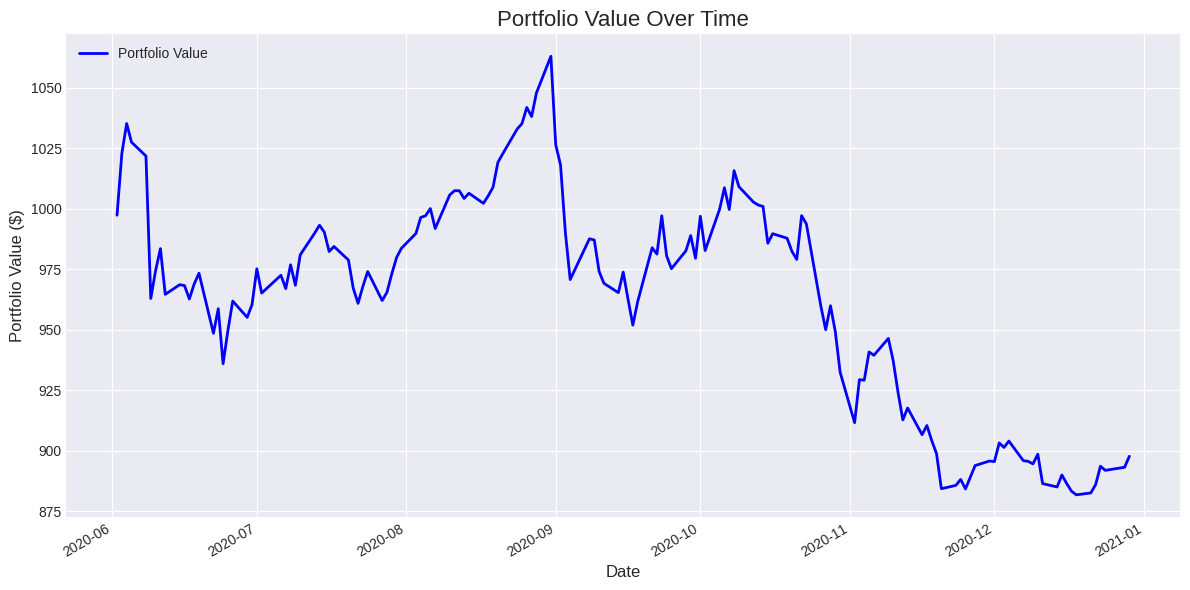

In [ ]:
# Train the Lasso model and generate signals
lasso_model = train_lasso(X_train, y_train)
a_signals = generate_signals(lasso_model, X_test)

# Backtest the strategy
cumulative_returns = backtest(y_test, a_signals, 1000)

## Training and Testing on XLV ETF

In [92]:
import pandas as pd

# Define the tickers for healthcare stocks and corresponding ETF
tickers = ['JNJ', 'PFE', 'MRK', 'ABT', 'BMY', 'AMGN', 'GILD', 'LLY', 'XLV']
start_date = '2022-01-01'
end_date = '2023-01-01'

# Assuming fetch_data and compute_returns are predefined functions
data = fetch_data(tickers, start_date, end_date)
returns = compute_returns(data)

# Separate the ETF from stock returns
X = returns.drop(columns='XLV')  # Drop the ETF column to isolate stock returns
y = returns['XLV']  # The target variable is the returns of the ETF



[*********************100%%**********************]  9 of 9 completed


Date
2022-06-01   -0.003277
2022-06-02    0.000163
2022-06-03    0.001714
2022-06-06    0.003528
2022-06-07    0.001231
                ...   
2022-12-23    0.001629
2022-12-27    0.001641
2022-12-28    0.000708
2022-12-29   -0.001743
2022-12-30   -0.002235
Length: 148, dtype: float64


<ipython-input-7-06eed7143687>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


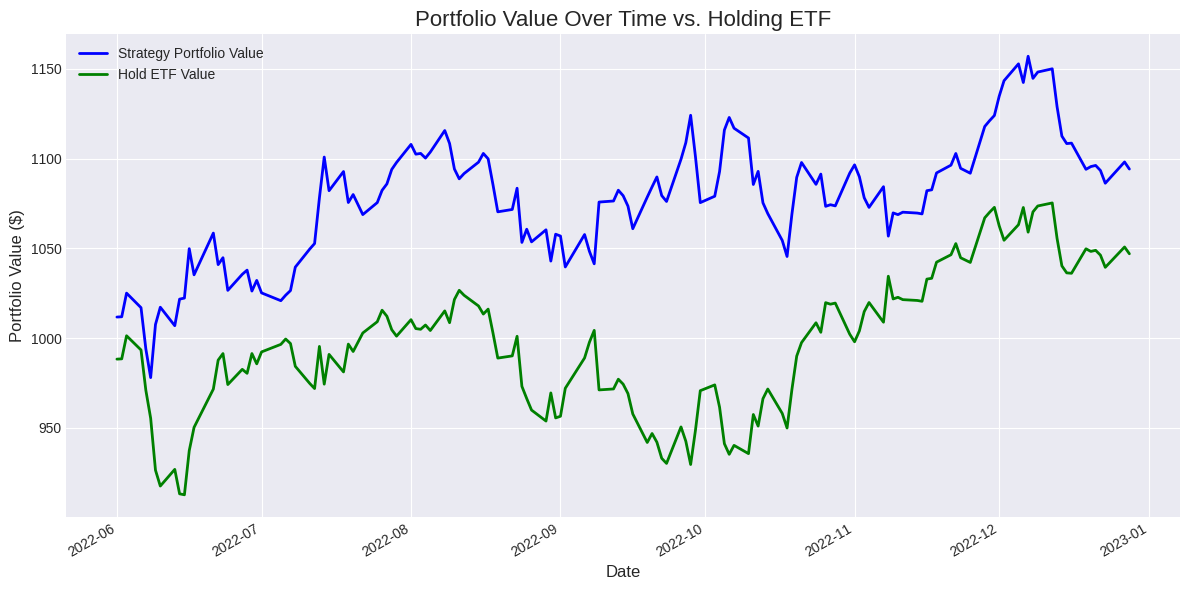

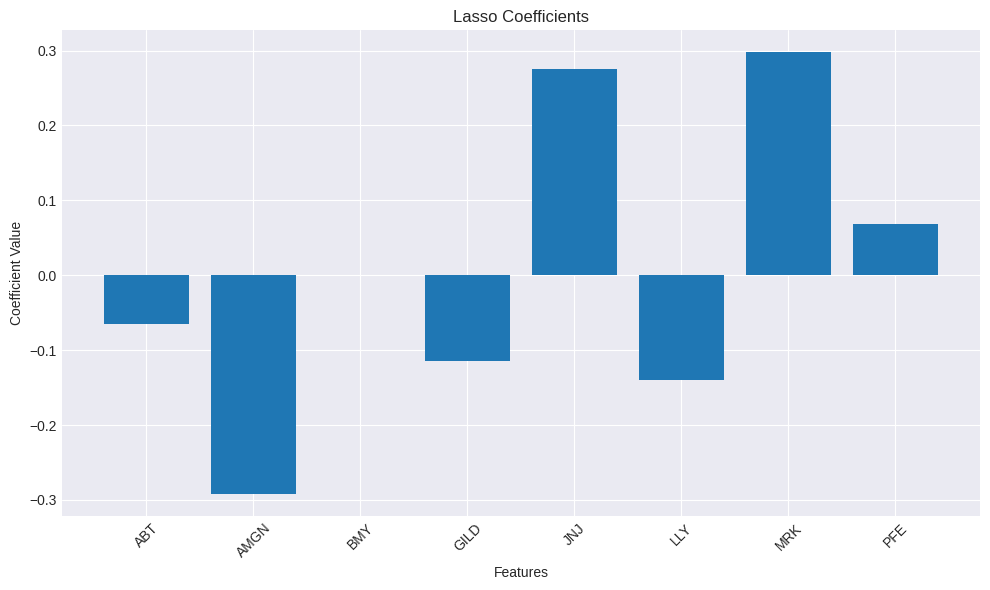

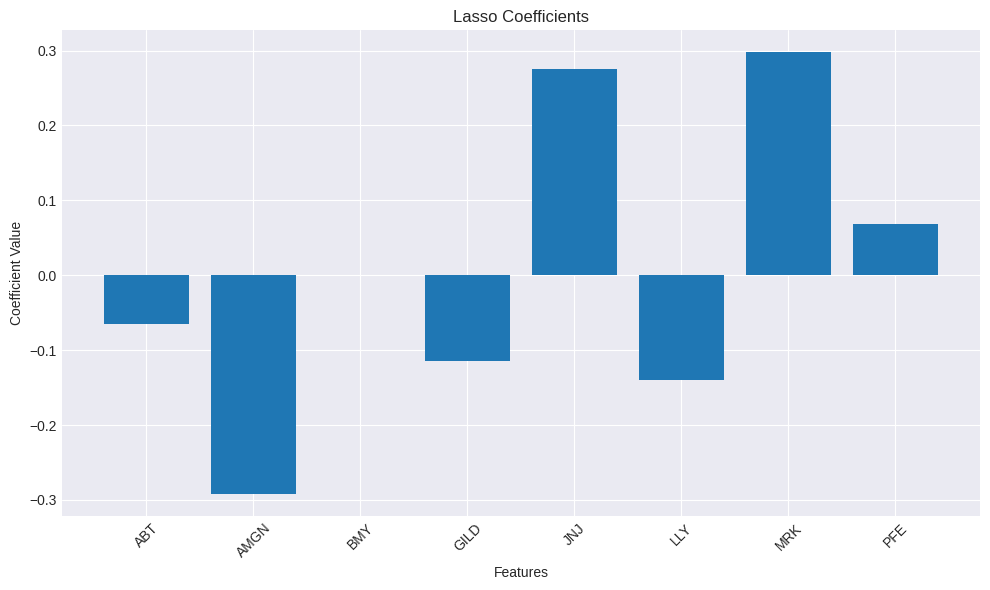

In [93]:
# Example setup with date cutoff
cutoff_date = '2022-06-01'  # Choose an appropriate cutoff date

# Prepare the features using rolling windows
X_rolled = prepare_features(X)
y_rolled = y.shift(-2)  # Align target with the input features

# Drop rows with NaN values which might be introduced by rolling and shifting
X_rolled = X_rolled.dropna()
y_rolled = y_rolled.dropna()[2:]

# Split the data chronologically
X_train = X_rolled.loc[X_rolled.index < cutoff_date]
X_test = X_rolled.loc[X_rolled.index >= cutoff_date]
y_train = y_rolled.loc[y_rolled.index < cutoff_date]
y_test = y_rolled.loc[y_rolled.index >= cutoff_date]

# Train the Lasso model and generate signals
lasso_model = train_lasso(X_train, y_train)
signals = generate_signals(lasso_model, X_test)

# Backtest the strategy
cumulative_returns = backtest(y_test, signals, 1000)

lasso_coefs = lasso_model.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(lasso_coefs)), lasso_coefs)
plt.xticks(range(len(lasso_coefs)), X_train.columns, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.tight_layout()
plt.show()

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(lasso_coefs)), lasso_coefs)
plt.xticks(range(len(lasso_coefs)), X_train.columns, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.tight_layout()
plt.show()

Date
2020-06-01    0.004295
2020-06-02    0.000089
2020-06-03   -0.008588
2020-06-04   -0.002997
2020-06-05   -0.000952
                ...   
2022-12-23    0.004491
2022-12-27   -0.001365
2022-12-28   -0.003614
2022-12-29    0.000144
2022-12-30    0.000086
Length: 653, dtype: float64


<ipython-input-8-e5794ee162ed>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


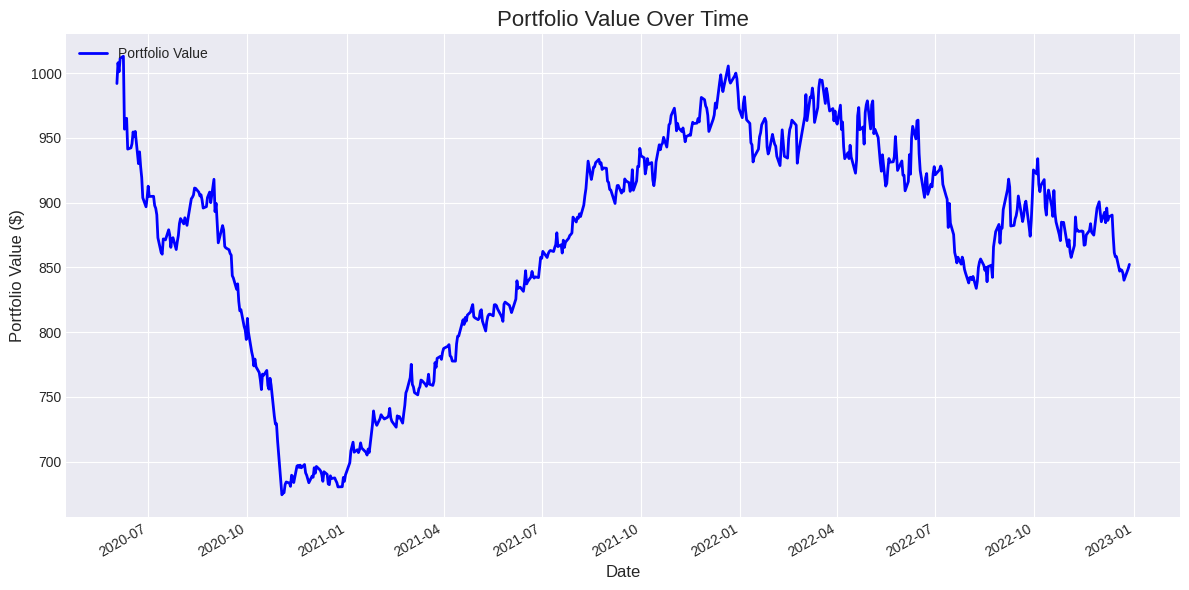

In [ ]:
# Train the Adaptive Lasso model and generate signals
a_lasso_model = train_alasso(X_train, y_train)
a_signals = generate_signals(a_lasso_model, X_test)

# Backtest the strategy
a_cumulative_returns = backtest(y_test, a_signals, 1000)

In [88]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
start_date = '2018-01-01'
end_date = '2023-01-01'

data = fetch_data(tickers, start_date, end_date)
returns = compute_returns(data)
X = returns.drop(columns='SPY')
y = returns['SPY']
# Example setup with date cutoff
cutoff_date = '2020-06-01'  # Choose an appropriate cutoff date


[*********************100%%**********************]  5 of 5 completed


Date
2020-06-01    0.001886
2020-06-02    0.003869
2020-06-03    0.002780
2020-06-04   -0.000982
2020-06-05    0.002745
                ...   
2022-12-23   -0.001322
2022-12-27   -0.007578
2022-12-28   -0.006404
2022-12-29   -0.001041
2022-12-30    0.001619
Length: 653, dtype: float64


<ipython-input-7-06eed7143687>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


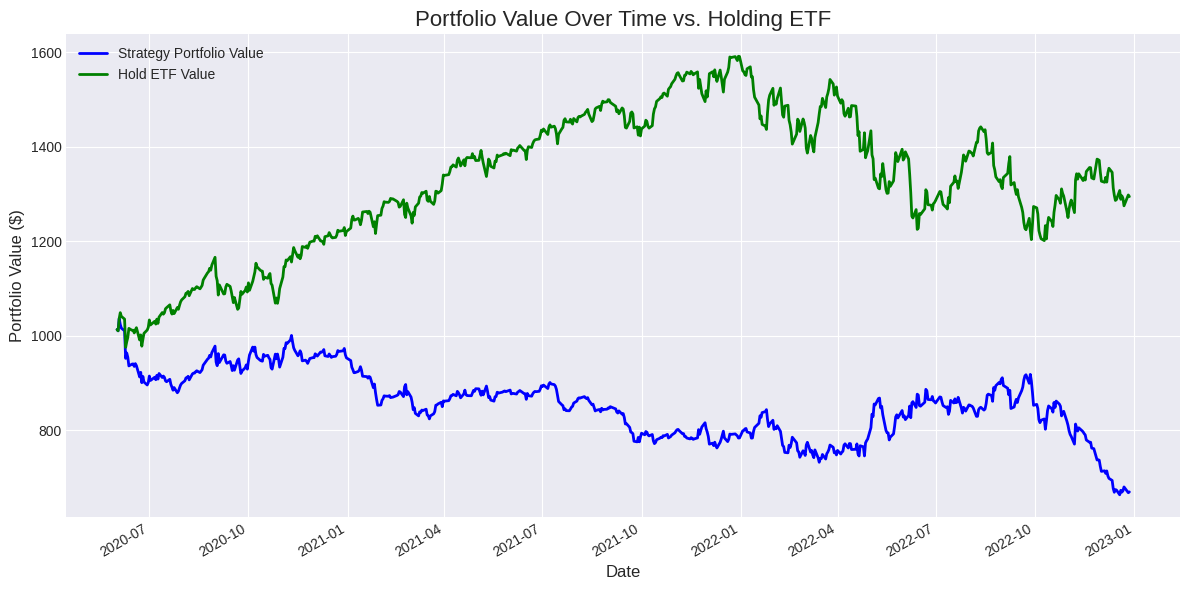

In [84]:

# Prepare the features using rolling windows
X_rolled = prepare_features(X)
y_rolled = y.shift(-2)  # Align target with the input features

# Drop rows with NaN values which might be introduced by rolling and shifting
X_rolled = X_rolled.dropna()
y_rolled = y_rolled.dropna()[2:]

# Split the data chronologically
X_train = X_rolled.loc[X_rolled.index < cutoff_date]
X_test = X_rolled.loc[X_rolled.index >= cutoff_date]
y_train = y_rolled.loc[y_rolled.index < cutoff_date]
y_test = y_rolled.loc[y_rolled.index >= cutoff_date]

# Train the Adaptive Lasso model and generate signals
a_lasso_model = train_alasso(X_train, y_train)
a_signals = generate_signals(a_lasso_model, X_test)

# Backtest the strategy
a_cumulative_returns = backtest(y_test, a_signals, 1000)

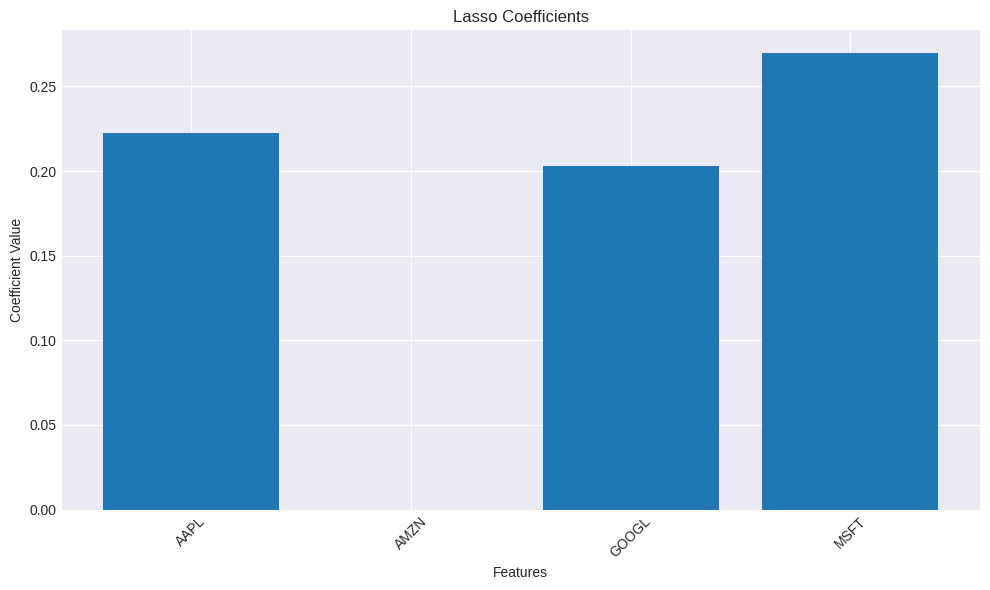

In [ ]:
lasso_coefs = a_lasso_model.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(lasso_coefs)), lasso_coefs)
plt.xticks(range(len(lasso_coefs)), X_train.columns, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb

def train_gbtree(X_train, y_train, params=None):
    if params is None:
        params = {
            'objective': 'reg:squarederror',  # for regression task
            'eval_metric': 'rmse'  # root mean squared error
        }

    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Training the model
    model = xgb.train(params, dtrain)

    return model


In [86]:
import pandas as pd

def generate_signals_tree(model, X_data):
    dmatrix = xgb.DMatrix(X_data)
    predictions = model.predict(dmatrix)

    signals = pd.Series(predictions, index=X_data.index)
    signals = signals.apply(lambda x: 1 if x > 0 else -1)

    return signals


<ipython-input-7-06eed7143687>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


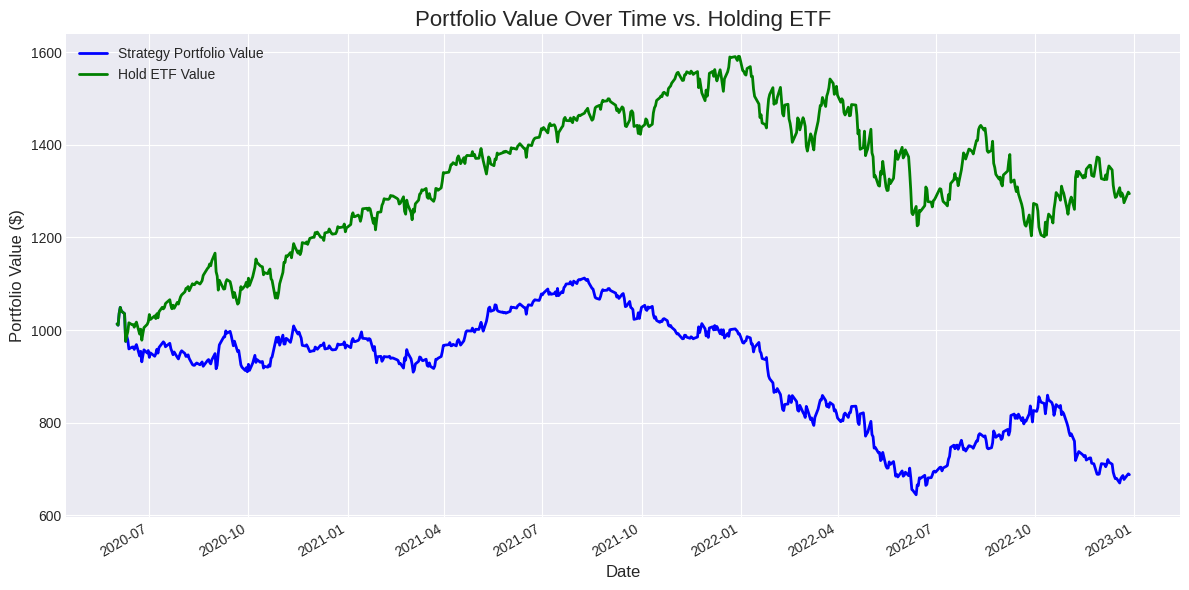

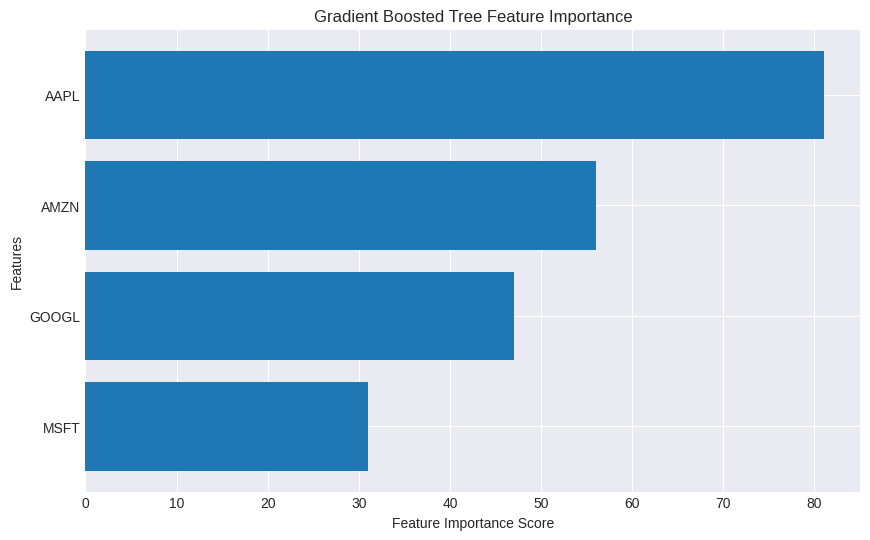

In [89]:
# Example setup with date cutoff
cutoff_date = '2020-06-01'  # Choose an appropriate cutoff date

# Prepare the features using rolling windows
X_rolled = prepare_features(X)
y_rolled = y.shift(-2)  # Align target with the input features

# Drop rows with NaN values which might be introduced by rolling and shifting
X_rolled = X_rolled.dropna()
y_rolled = y_rolled.dropna()[2:]

# Split the data chronologically
X_train = X_rolled.loc[X_rolled.index < cutoff_date]
X_test = X_rolled.loc[X_rolled.index >= cutoff_date]
y_train = y_rolled.loc[y_rolled.index < cutoff_date]
y_test = y_rolled.loc[y_rolled.index >= cutoff_date]

# Train the Lasso model and generate signals
tree_model = train_gbtree(X_train, y_train)
signals = generate_signals_tree(tree_model, X_test)

# Backtest the strategy
cumulative_returns = backtest(y_test, signals, 1000)

importance = tree_model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), scores, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Gradient Boosted Tree Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
start_date = '2020-01-01'
end_date = '2021-01-01'

data = fetch_data(tickers, start_date, end_date)
returns = compute_returns(data)
X = returns.drop(columns='SPY')
y = returns['SPY']

[*********************100%%**********************]  5 of 5 completed


In [ ]:
tickers = ['DAL', 'AAL', 'UAL', 'LUV', 'EXPE', 'JETS']
start_date = '2020-01-01'
end_date = '2021-01-01'

data = fetch_data(tickers, start_date, end_date)
returns = compute_returns(data)
X = returns.drop(columns=['JETS'])  # Remove JETS ETF from features
y = returns['JETS']

[*********************100%%**********************]  6 of 6 completed


<ipython-input-8-e5794ee162ed>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


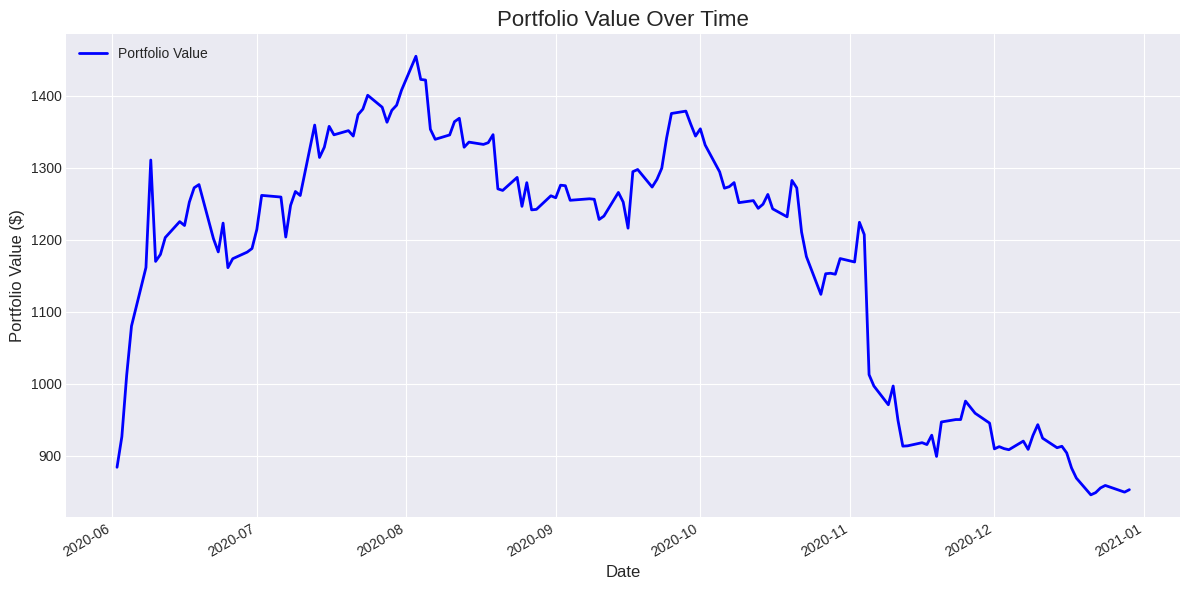

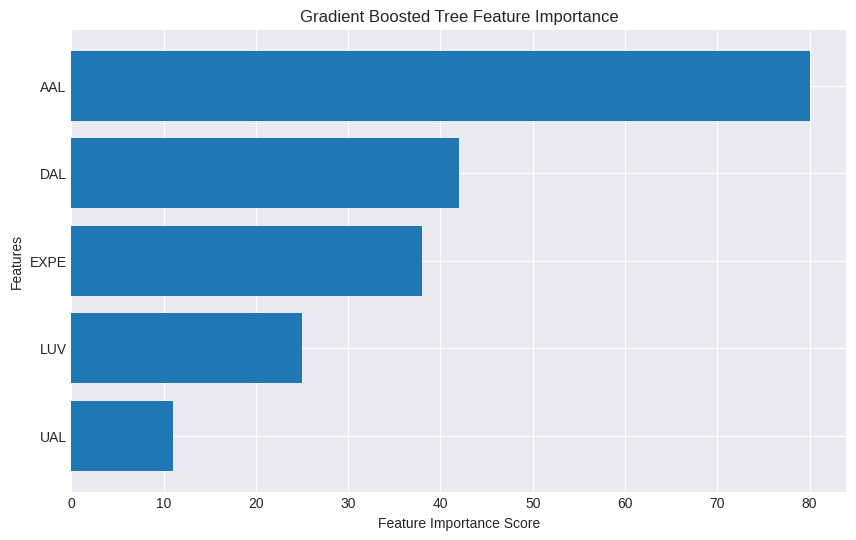

In [ ]:
# Example setup with date cutoff
cutoff_date = '2020-06-01'  # Choose an appropriate cutoff date

# Prepare the features using rolling windows
X_rolled = prepare_features(X)
y_rolled = y.shift(-2)  # Align target with the input features

# Drop rows with NaN values which might be introduced by rolling and shifting
X_rolled = X_rolled.dropna()
y_rolled = y_rolled.dropna()[2:]

# Split the data chronologically
X_train = X_rolled.loc[X_rolled.index < cutoff_date]
X_test = X_rolled.loc[X_rolled.index >= cutoff_date]
y_train = y_rolled.loc[y_rolled.index < cutoff_date]
y_test = y_rolled.loc[y_rolled.index >= cutoff_date]

# Train the Lasso model and generate signals
tree_model = train_gbtree(X_train, y_train)
signals = generate_signals_tree(tree_model, X_test)

# Backtest the strategy
cumulative_returns = backtest(y_test, signals, 1000)

importance = tree_model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), scores, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Gradient Boosted Tree Feature Importance')
plt.gca().invert_yaxis()
plt.show()
